# Text Preprocessing and Wor2vec Training

## 1. Import Libraries and Load Data:

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import gensim
from gensim.models import Word2Vec

from sklearn.decomposition import PCA

nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

from bs4 import BeautifulSoup
import re

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
data = pd.read_csv('./drive/MyDrive/Text_Preprocessing_and_Wor2vec_Training_Data/all_data.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21559 entries, 0 to 21558
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   book_title     21559 non-null  object 
 1   Book_series    8780 non-null   object 
 2   book_rating    21559 non-null  float64
 3   book_author    21559 non-null  object 
 4   genre          21438 non-null  object 
 5   reviewer_name  21534 non-null  object 
 6   review         20817 non-null  object 
 7   ID             21559 non-null  int64  
dtypes: float64(1), int64(1), object(6)
memory usage: 1.3+ MB


In [5]:
data.head()

,book_title,Book_series,book_rating,book_author,genre,reviewer_name,review,ID
0,A Court of Wings and Ruin,(A Court of Thorns and Roses #3),4.51,Sarah J. Maas,"Fantasy, Romance, Young Adult, New Adult",emma,202.\nThat’s the number of times that the word...,1
1,A Court of Wings and Ruin,(A Court of Thorns and Roses #3),4.51,Sarah J. Maas,"Fantasy, Romance, Young Adult, New Adult",Em (RunawayWithDreamthieves),I need a black silk robe and a balcony to wear...,2
2,A Court of Wings and Ruin,(A Court of Thorns and Roses #3),4.51,Sarah J. Maas,"Fantasy, Romance, Young Adult, New Adult",Cait • A Page with a View,THIS BOOK TOTALLY WRECKED ME. In the best poss...,3
3,A Court of Wings and Ruin,(A Court of Thorns and Roses #3),4.51,Sarah J. Maas,"Fantasy, Romance, Young Adult, New Adult",Natalie Monroe,"3.75 stars\n""Rhys stepped off the stairs and t...",4
4,A Court of Wings and Ruin,(A Court of Thorns and Roses #3),4.51,Sarah J. Maas,"Fantasy, Romance, Young Adult, New Adult",Emily May,I wish so much that I could tell you I loved t...,5


In [6]:
data['review'][0]

"202.\nThat’s the number of times that the word “mate,” in any of its hellish forms, is used in this book.\nTWO.\nHUNDRED.\nAND.\nTWO.\nhttps://emmareadstoomuch.wordpress.co...\nThat statistic alone should be enough to justify this one star rating. If you feel satisfied enough to just remove yourself from this review, run with that feeling. Because I have, like. Seven pages of sh*t to complain about.\nThat’s if I’m efficient.\nAnd I’ve never been an efficient reviewer. Once. In my life. I counted two hundred (and two) uses of a word over seven hundred pages. That shouldn’t scream “rational and in control of her passionate fury” to you.\nSo buckle up, buttercup. We’ve got some categories to run through.\nDISCLAIMER : This review is teeming with spoilers. It is also X-rated, due to the strength of my anger and the copious sex scenes in the source material.\nI HATE THESE CHARACTERS\nRhys makes me cringe harder than Renee Zellweger in Bridget Jones’ Diary. (At least that movie has both Col

In [7]:
data['review'][1]

'I need a black silk robe and a balcony to wear it on because if I’m gonna drag myself around my house still being disappointed, I at least wanna look good.\n❗ full disclosure❗ there will be so many bad vibes around this review, it\'s like in the prisoner of azkaban you’ll need to charge all the negativity away with a stag bc there\'s just so much salt and bitterness seeping through my follicles I\'m literally just a bottomless pit of negativity right now.\n*raises my arms to sensually embrace the metaphorical shower of said salt and bitterness*\n⚠ also before y\'all come for me please consider I\'ve been through some stuff...for example I\'ve had to get out of bed for several hours every day this week\n⚠ UNMARKED SPOILERS because I am a lazy shit I guess\n____________________________\nAaah. When you remain stubbornly indifferent towards a book that everyone else loves and you feel like the unlikely hero in high school movies being pelted with dodgeballs!! feels bad, pal. Especially wh

**Insights**
1. I have never read "A Court of Wings and Ruin" but the first 2 reviews we have looked at suggest it's a very bad book :(.
2. We have null values of review column, So we will drop these rows.
3. The sentences contain skip character (new line represented by \n) and special charachters have \ before them so we need to take care of them in preprocessing.
4. The Reviews contains URLs.

In [8]:
# Drop rows with null in review column:
data = data.dropna(subset=['review'])
data.isna().sum()

,0
book_title,0
Book_series,12203
book_rating,0
book_author,0
genre,47
reviewer_name,0
review,0
ID,0


Now we haven't null values in review column.

## 2.  Text Preprocessing:

### 2.1 Text Cleaning:

#### 2.1.1 Remove URLs:

In [9]:
def remove_urls(text):
    return re.sub(r'http[s]?://\S+|www\.\S+', '', text)

In [10]:
remove_urls('http://test.com some testing https://www.example.com')

' some testing '

In [11]:
data['cleaned_review'] = data['review'].apply(remove_urls)

#### 2.1.2 Remove HTML tags:

In [12]:
def remove_html_tags(text):
    return BeautifulSoup(text, "html.parser").get_text()

In [13]:
remove_html_tags('<p>Test the function</p>')

'Test the function'

In [14]:
data['cleaned_review'] = data['cleaned_review'].apply(remove_html_tags)

#### 2.1.3 Remove Special charachters:

In [15]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'\s+', ' ', text)  # Remove extra spaces, newlines (\n), and tabs (\t)
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove special characters except spaces
    return text.strip()  # Remove leading/trailing spaces

In [16]:
clean_text('This movie was amazing!\n\nLoved it.\t\tSo good!')

'this movie was amazing loved it so good'

In [17]:
data['cleaned_review'] = data['cleaned_review'].apply(clean_text)

In [18]:
data['cleaned_review'][2]

'this book totally wrecked me in the best possible way because im thrilled to cry for a day straight idk first of all the scope of this story is extraordinary events from the first half that seemed so important at the time now feel like minuscule details in the face of this epic plot i love how maas writes such complex characters who have had their lives shattered in a variety of ways yet still keep fighting for each other and work to create a new life with the family they chose feyres growth from the first book where she had such low selfworth is beyond inspirational as she finds the ability to completely forgive  love herself and everything shes been shes still a flawed character who makes some sketchy calls and is continually healing and thats what i love most about this book every single character is broken and healing lucien elain nesta cassian azriel mor rhys amren even tamlin everyone and the amount they care about each other is just maas manages to juggle a wide range of charac

### 2.2 Tokenization:

In [19]:
data['cleaned_review'][0]

'thats the number of times that the word mate in any of its hellish forms is used in this book two hundred and two that statistic alone should be enough to justify this one star rating if you feel satisfied enough to just remove yourself from this review run with that feeling because i have like seven pages of sht to complain about thats if im efficient and ive never been an efficient reviewer once in my life i counted two hundred and two uses of a word over seven hundred pages that shouldnt scream rational and in control of her passionate fury to you so buckle up buttercup weve got some categories to run through disclaimer  this review is teeming with spoilers it is also xrated due to the strength of my anger and the copious sex scenes in the source material i hate these characters rhys makes me cringe harder than renee zellweger in bridget jones diary at least that movie has both colin firth and hugh grant to distract me from renee viciously critiquing her own body and like spilling 

In [20]:
word_tokenize(data['cleaned_review'][0])

['thats',
 'the',
 'number',
 'of',
 'times',
 'that',
 'the',
 'word',
 'mate',
 'in',
 'any',
 'of',
 'its',
 'hellish',
 'forms',
 'is',
 'used',
 'in',
 'this',
 'book',
 'two',
 'hundred',
 'and',
 'two',
 'that',
 'statistic',
 'alone',
 'should',
 'be',
 'enough',
 'to',
 'justify',
 'this',
 'one',
 'star',
 'rating',
 'if',
 'you',
 'feel',
 'satisfied',
 'enough',
 'to',
 'just',
 'remove',
 'yourself',
 'from',
 'this',
 'review',
 'run',
 'with',
 'that',
 'feeling',
 'because',
 'i',
 'have',
 'like',
 'seven',
 'pages',
 'of',
 'sht',
 'to',
 'complain',
 'about',
 'thats',
 'if',
 'im',
 'efficient',
 'and',
 'ive',
 'never',
 'been',
 'an',
 'efficient',
 'reviewer',
 'once',
 'in',
 'my',
 'life',
 'i',
 'counted',
 'two',
 'hundred',
 'and',
 'two',
 'uses',
 'of',
 'a',
 'word',
 'over',
 'seven',
 'hundred',
 'pages',
 'that',
 'shouldnt',
 'scream',
 'rational',
 'and',
 'in',
 'control',
 'of',
 'her',
 'passionate',
 'fury',
 'to',
 'you',
 'so',
 'buckle',
 'up'

In [21]:
data['tokens'] = data['cleaned_review'].apply(word_tokenize)

In [22]:
data.head()

,book_title,Book_series,book_rating,book_author,genre,reviewer_name,review,ID,cleaned_review,tokens
0,A Court of Wings and Ruin,(A Court of Thorns and Roses #3),4.51,Sarah J. Maas,"Fantasy, Romance, Young Adult, New Adult",emma,202.\nThat’s the number of times that the word...,1,thats the number of times that the word mate i...,"[thats, the, number, of, times, that, the, wor..."
1,A Court of Wings and Ruin,(A Court of Thorns and Roses #3),4.51,Sarah J. Maas,"Fantasy, Romance, Young Adult, New Adult",Em (RunawayWithDreamthieves),I need a black silk robe and a balcony to wear...,2,i need a black silk robe and a balcony to wear...,"[i, need, a, black, silk, robe, and, a, balcon..."
2,A Court of Wings and Ruin,(A Court of Thorns and Roses #3),4.51,Sarah J. Maas,"Fantasy, Romance, Young Adult, New Adult",Cait • A Page with a View,THIS BOOK TOTALLY WRECKED ME. In the best poss...,3,this book totally wrecked me in the best possi...,"[this, book, totally, wrecked, me, in, the, be..."
3,A Court of Wings and Ruin,(A Court of Thorns and Roses #3),4.51,Sarah J. Maas,"Fantasy, Romance, Young Adult, New Adult",Natalie Monroe,"3.75 stars\n""Rhys stepped off the stairs and t...",4,stars rhys stepped off the stairs and took my ...,"[stars, rhys, stepped, off, the, stairs, and, ..."
4,A Court of Wings and Ruin,(A Court of Thorns and Roses #3),4.51,Sarah J. Maas,"Fantasy, Romance, Young Adult, New Adult",Emily May,I wish so much that I could tell you I loved t...,5,i wish so much that i could tell you i loved t...,"[i, wish, so, much, that, i, could, tell, you,..."


### 2.3 Remove Stopwords:

In [23]:
[word for word in data['tokens'][0] if word not in stop_words]

['thats',
 'number',
 'times',
 'word',
 'mate',
 'hellish',
 'forms',
 'used',
 'book',
 'two',
 'hundred',
 'two',
 'statistic',
 'alone',
 'enough',
 'justify',
 'one',
 'star',
 'rating',
 'feel',
 'satisfied',
 'enough',
 'remove',
 'review',
 'run',
 'feeling',
 'like',
 'seven',
 'pages',
 'sht',
 'complain',
 'thats',
 'im',
 'efficient',
 'ive',
 'never',
 'efficient',
 'reviewer',
 'life',
 'counted',
 'two',
 'hundred',
 'two',
 'uses',
 'word',
 'seven',
 'hundred',
 'pages',
 'shouldnt',
 'scream',
 'rational',
 'control',
 'passionate',
 'fury',
 'buckle',
 'buttercup',
 'weve',
 'got',
 'categories',
 'run',
 'disclaimer',
 'review',
 'teeming',
 'spoilers',
 'also',
 'xrated',
 'due',
 'strength',
 'anger',
 'copious',
 'sex',
 'scenes',
 'source',
 'material',
 'hate',
 'characters',
 'rhys',
 'makes',
 'cringe',
 'harder',
 'renee',
 'zellweger',
 'bridget',
 'jones',
 'diary',
 'least',
 'movie',
 'colin',
 'firth',
 'hugh',
 'grant',
 'distract',
 'renee',
 'vicious

In [24]:
def remove_stopwords(tokens):
    return [word for word in tokens if word not in stop_words]

In [25]:
data['cleaned_tokens'] = data['tokens'].apply(remove_stopwords)

In [26]:
data.head()

,book_title,Book_series,book_rating,book_author,genre,reviewer_name,review,ID,cleaned_review,tokens,cleaned_tokens
0,A Court of Wings and Ruin,(A Court of Thorns and Roses #3),4.51,Sarah J. Maas,"Fantasy, Romance, Young Adult, New Adult",emma,202.\nThat’s the number of times that the word...,1,thats the number of times that the word mate i...,"[thats, the, number, of, times, that, the, wor...","[thats, number, times, word, mate, hellish, fo..."
1,A Court of Wings and Ruin,(A Court of Thorns and Roses #3),4.51,Sarah J. Maas,"Fantasy, Romance, Young Adult, New Adult",Em (RunawayWithDreamthieves),I need a black silk robe and a balcony to wear...,2,i need a black silk robe and a balcony to wear...,"[i, need, a, black, silk, robe, and, a, balcon...","[need, black, silk, robe, balcony, wear, im, g..."
2,A Court of Wings and Ruin,(A Court of Thorns and Roses #3),4.51,Sarah J. Maas,"Fantasy, Romance, Young Adult, New Adult",Cait • A Page with a View,THIS BOOK TOTALLY WRECKED ME. In the best poss...,3,this book totally wrecked me in the best possi...,"[this, book, totally, wrecked, me, in, the, be...","[book, totally, wrecked, best, possible, way, ..."
3,A Court of Wings and Ruin,(A Court of Thorns and Roses #3),4.51,Sarah J. Maas,"Fantasy, Romance, Young Adult, New Adult",Natalie Monroe,"3.75 stars\n""Rhys stepped off the stairs and t...",4,stars rhys stepped off the stairs and took my ...,"[stars, rhys, stepped, off, the, stairs, and, ...","[stars, rhys, stepped, stairs, took, hand, nig..."
4,A Court of Wings and Ruin,(A Court of Thorns and Roses #3),4.51,Sarah J. Maas,"Fantasy, Romance, Young Adult, New Adult",Emily May,I wish so much that I could tell you I loved t...,5,i wish so much that i could tell you i loved t...,"[i, wish, so, much, that, i, could, tell, you,...","[wish, much, could, tell, loved, book, didnt, ..."


### 2.4 Lemmatization:

In [27]:
print('Raw\n', data['cleaned_tokens'][0])
print('Lemmatized\n', [lemmatizer.lemmatize(word) for word in data['cleaned_tokens'][0]])

Raw
 ['thats', 'number', 'times', 'word', 'mate', 'hellish', 'forms', 'used', 'book', 'two', 'hundred', 'two', 'statistic', 'alone', 'enough', 'justify', 'one', 'star', 'rating', 'feel', 'satisfied', 'enough', 'remove', 'review', 'run', 'feeling', 'like', 'seven', 'pages', 'sht', 'complain', 'thats', 'im', 'efficient', 'ive', 'never', 'efficient', 'reviewer', 'life', 'counted', 'two', 'hundred', 'two', 'uses', 'word', 'seven', 'hundred', 'pages', 'shouldnt', 'scream', 'rational', 'control', 'passionate', 'fury', 'buckle', 'buttercup', 'weve', 'got', 'categories', 'run', 'disclaimer', 'review', 'teeming', 'spoilers', 'also', 'xrated', 'due', 'strength', 'anger', 'copious', 'sex', 'scenes', 'source', 'material', 'hate', 'characters', 'rhys', 'makes', 'cringe', 'harder', 'renee', 'zellweger', 'bridget', 'jones', 'diary', 'least', 'movie', 'colin', 'firth', 'hugh', 'grant', 'distract', 'renee', 'viciously', 'critiquing', 'body', 'like', 'spilling', 'coffee', 'whatever', 'capable', 'two', '

In [28]:
def lemmatize_fn(tokens):
    return [lemmatizer.lemmatize(word) for word in tokens]

In [29]:
data['lemmatized_tokens'] = data['cleaned_tokens'].apply(lemmatize_fn)

## 3. EDA:

### 3.1 Rating Distribution Analysis:

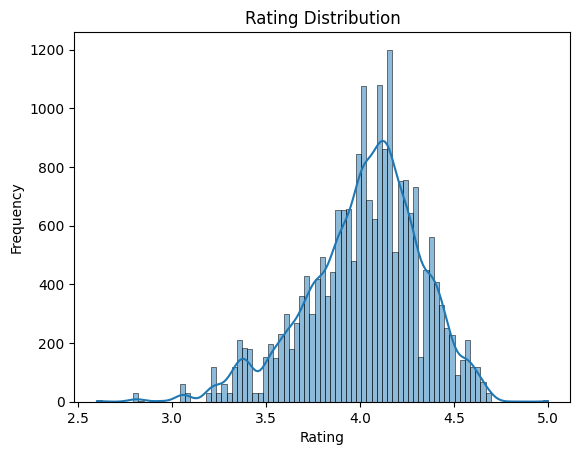

In [30]:
sns.histplot(data['book_rating'], kde=True)
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Rating Distribution')
plt.show()

### 3.2 Text Length vs. Ratings:

In [31]:
data['num_of_cleaned_tokens'] = [len(tokens) for tokens in data['lemmatized_tokens']]

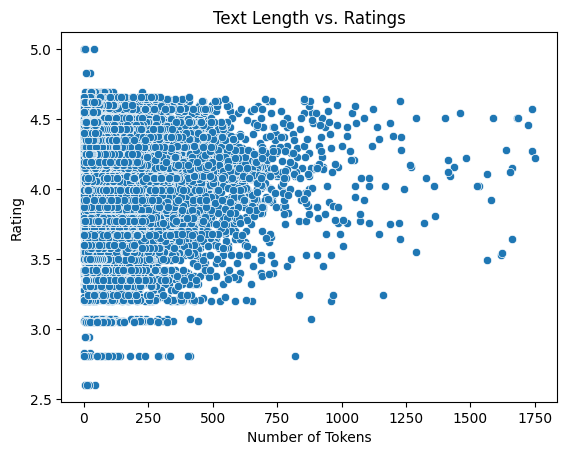

In [32]:
sns.scatterplot(x='num_of_cleaned_tokens', y='book_rating', data=data)
plt.xlabel('Number of Tokens')
plt.ylabel('Rating')
plt.title('Text Length vs. Ratings')
plt.show()

### 3.3 Word Frequency Visualization:

#### 3.3.1 Word Colud:

In [33]:
# Convert token lists to single text strings
text_before = " ".join(data['review'])

In [34]:
text_after = " ".join([" ".join(tokens) for tokens in data['lemmatized_tokens'] if tokens])  # Avoid empty lists

In [35]:
def generate_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title, fontsize=14)
    plt.show()

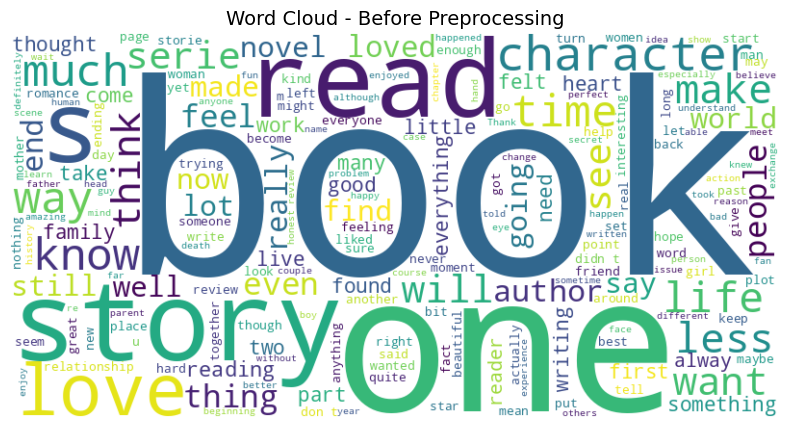

In [36]:
generate_wordcloud(text_before, "Word Cloud - Before Preprocessing")

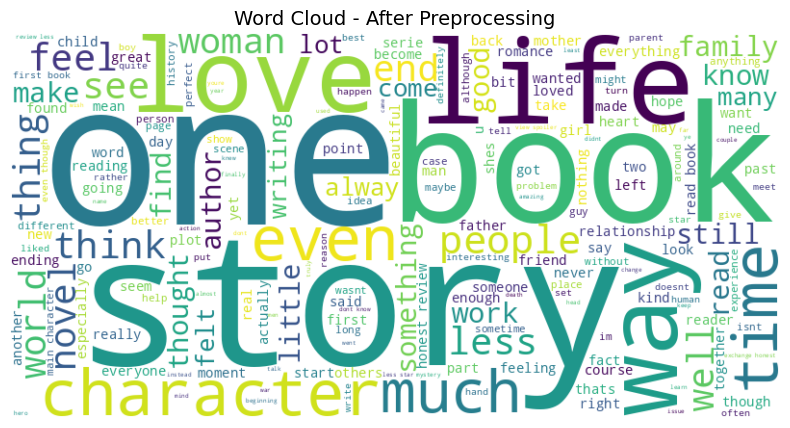

In [37]:
generate_wordcloud(text_after, "Word Cloud - After Preprocessing")

#### 3.3.2 Bar Chart:

In [38]:
def generate_bar_chart(text, title):
    words = text.split()
    word_counts = Counter(words)
    common_words = word_counts.most_common(10)  # Top 10 words
    words, counts = zip(*common_words)

    plt.figure(figsize=(10, 5))
    plt.bar(words, counts, color='skyblue')
    plt.xlabel("Words", fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.title(title, fontsize=14)
    plt.xticks(rotation=45)
    plt.show()

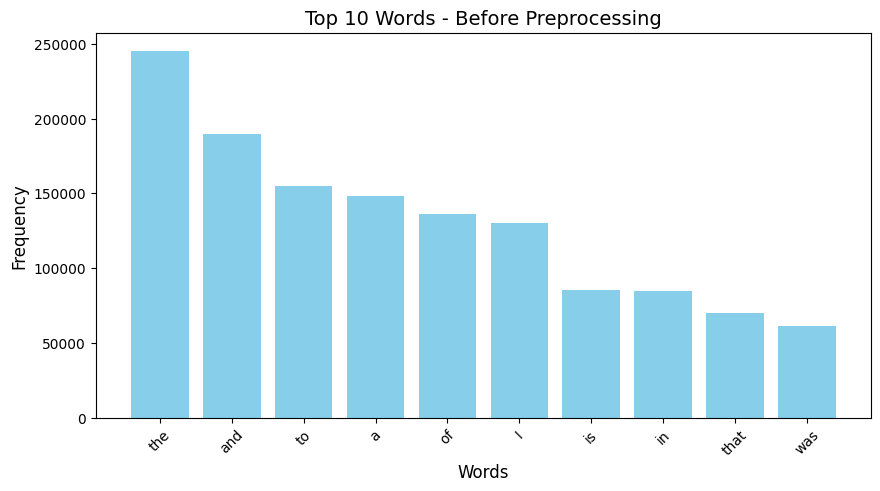

In [39]:
generate_bar_chart(text_before, "Top 10 Words - Before Preprocessing")

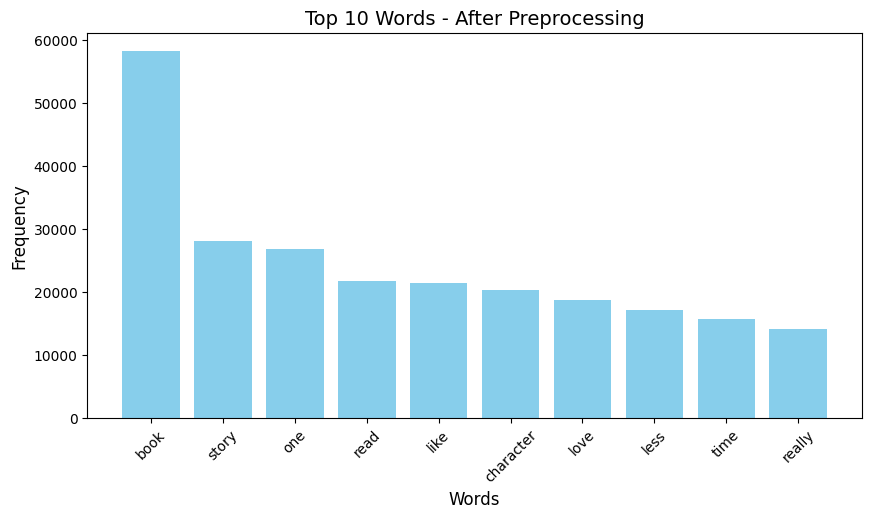

In [40]:
generate_bar_chart(text_after, "Top 10 Words - After Preprocessing")

### 3.4 Comparison Visualization:

In [41]:
print('Original:\n', data['review'][0])
print('################')
print('Preprocessed:\n', data['cleaned_review'][0])

Original:
 202.
That’s the number of times that the word “mate,” in any of its hellish forms, is used in this book.
TWO.
HUNDRED.
AND.
TWO.
https://emmareadstoomuch.wordpress.co...
That statistic alone should be enough to justify this one star rating. If you feel satisfied enough to just remove yourself from this review, run with that feeling. Because I have, like. Seven pages of sh*t to complain about.
That’s if I’m efficient.
And I’ve never been an efficient reviewer. Once. In my life. I counted two hundred (and two) uses of a word over seven hundred pages. That shouldn’t scream “rational and in control of her passionate fury” to you.
So buckle up, buttercup. We’ve got some categories to run through.
DISCLAIMER : This review is teeming with spoilers. It is also X-rated, due to the strength of my anger and the copious sex scenes in the source material.
I HATE THESE CHARACTERS
Rhys makes me cringe harder than Renee Zellweger in Bridget Jones’ Diary. (At least that movie has both Colin 

## 4. Word2Vec Training on Text Reviews:

### 4.1 Train:

In [42]:
word2vec_model = Word2Vec(
    sentences=data['lemmatized_tokens'],  # Input: list of tokenized sentences
    vector_size=100,   # Size of word embeddings
    window=5,
    min_count=1,
    workers=4,
)

These warnings indicate that no training data was supplied to the Word2Vec model, Let us take a closer look.

In [43]:
data['lemmatized_tokens'].apply(len).describe()

,lemmatized_tokens
count,20817.000000
mean,152.180862
std,158.510815
min,0.000000
25%,42.000000
50%,111.000000
75%,209.000000
max,1749.000000


We have rows with 0 lemmatized tokens.

In [44]:
data[data['lemmatized_tokens'].apply(len) == 0].head(10)

,book_title,Book_series,book_rating,book_author,genre,reviewer_name,review,ID,cleaned_review,tokens,cleaned_tokens,lemmatized_tokens,num_of_cleaned_tokens
608,The Gentleman's Guide to Vice and Virtue,(Montague Siblings #1),4.16,Mackenzi Lee,"Historical, Historical Fiction, Young Adult, L...",Zoë,4.5/5,609,,[],[],[],0
1672,By Your Side,NaN,3.85,Kasie West,"Contemporary, Young Adult, Romance",Melissa ♥ Dog/Wolf Lover ♥ Martin,Not for me.,1673,not for me,"[not, for, me]",[],[],0
1808,Without Merit,NaN,3.91,Colleen Hoover,"Romance, Young Adult, Contemporary, New Adult,...",Lala BooksandLala,👀👀👀,1809,,[],[],[],0
2997,On Tyranny: Twenty Lessons from the Twentieth ...,NaN,4.23,Timothy Snyder,"Nonfiction, History, Politics, Philosophy, Wri...",Aida,چقدر به نظرم لازمه هممون این کتاب رو نه یک بار...,2998,,[],[],[],0
3212,Never Let You Go,NaN,3.97,Chevy Stevens,"Thriller, Mystery, Fiction, Suspense, Mystery ...",Rebbie,\,3213,,[],[],[],0
3386,If We Were Villains,NaN,4.03,M.L. Rio,"Mystery, Fiction, Contemporary, Thriller, Myst...",Lotte,4.5/5.,3387,,[],[],[],0
3708,The Baker's Secret,NaN,4.03,Stephen P. Kiernan,"Historical, Historical Fiction, Fiction, War, ...",Evaggelia Katsouli,Του στερώ τα 5 αστεράκια μόνο και μόνο γιατί θ...,3709,,[],[],[],0
3766,A Column of Fire,(Kingsbridge #3),4.22,Ken Follett,"Historical, Historical Fiction, Fiction",Nikoleta,Αρκετά ωραίο αλλά δεν είναι σαν τα δύο προηγού...,3767,,[],[],[],0
7028,Devil's Cut,(The Bourbon Kings #3),4.30,J.R. Ward,"Romance, Contemporary, Contemporary Romance, F...",The Empire of Me,https://youtu.be/l_mwHBsXmZ8,7029,,[],[],[],0
7454,The Last Tudor,(The Plantagenet and Tudor Novels #14),3.78,Philippa Gregory,"Historical, Historical Fiction, Fiction, Engli...",Александър,Завърших годината с един страхотен роман! Ревю...,7455,d,[d],[],[],0


The rows with 0 lemmatized tokens are not english or they don't contains words or the they contain stopwords only like "Not for ME", So we will remove these rows.

In [45]:
data = data[data['lemmatized_tokens'].apply(lambda x: isinstance(x, list) and len(x) > 0)]

In [46]:
data['lemmatized_tokens'].apply(len).describe()

,lemmatized_tokens
count,20750.000000
mean,152.672241
std,158.530084
min,1.000000
25%,43.000000
50%,111.000000
75%,209.000000
max,1749.000000


Let us train our word2vec again.

In [47]:
word2vec_model = Word2Vec(
    sentences=data['lemmatized_tokens'].tolist(),  # Input: list of tokenized sentences
    vector_size=100,   # Size of word embeddings
    window=5,
    min_count=1,
    workers=4,
)

In [48]:
word2vec_model.save("word2vec_reviews.model")

### 4.2 Evaluate:

In [49]:
similar_words = word2vec_model.wv.most_similar("great", topn=5)
print("Most similar words to 'great':", similar_words)

Most similar words to 'great': [('fantastic', 0.7995826005935669), ('good', 0.7720528841018677), ('wonderful', 0.7631810307502747), ('excellent', 0.7339392900466919), ('awesome', 0.7266591787338257)]


### 4.3 Visualization:

#### 4.3.1 Get the word vectors and their corresponding words:

In [50]:
words = list(word2vec_model.wv.index_to_key)  # Extract vocabulary
word_vectors = np.array([word2vec_model.wv[word] for word in words])  # Get vectors

#### 4.3.2 Reduce dimensions using PCA (100D → 2D):

In [51]:
pca = PCA(n_components=2)
word_vectors_pca = pca.fit_transform(word_vectors)

#### 4.3.3 Plot the words in 2D:

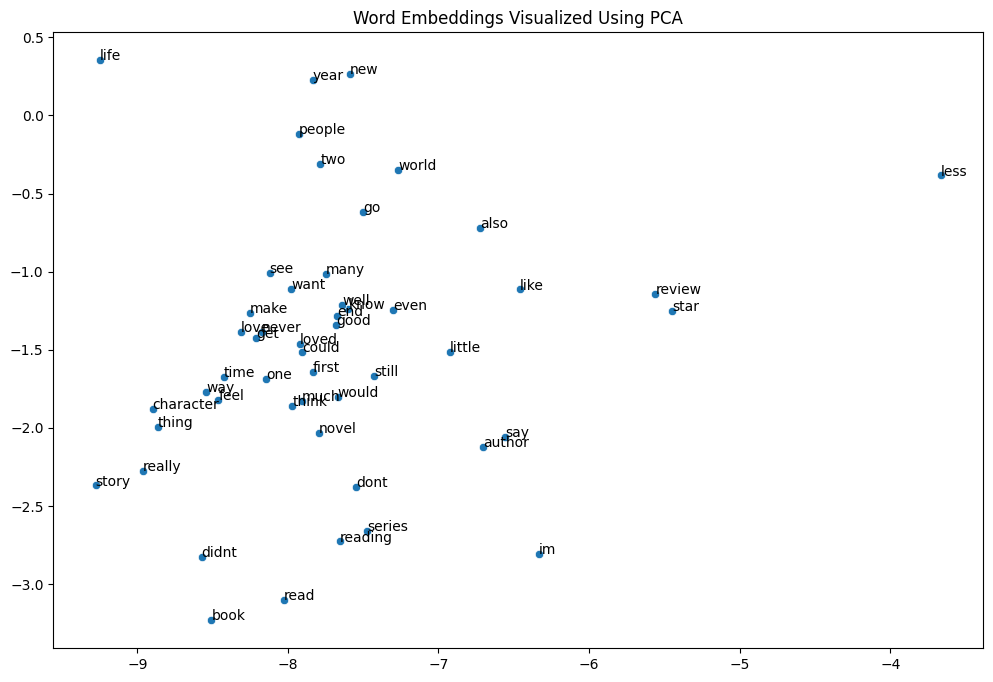

In [52]:
plt.figure(figsize=(12, 8))
sns.scatterplot(x=word_vectors_pca[:50, 0], y=word_vectors_pca[:50, 1])

# Annotate a few words
num_words_to_label = 50
for i, word in enumerate(words[:num_words_to_label]):
    plt.annotate(word, (word_vectors_pca[i, 0], word_vectors_pca[i, 1]))

plt.title("Word Embeddings Visualized Using PCA")
plt.show()